# 🔍 ViT-Tiny — Attention Map Visualisation
**Loads the trained checkpoint and visualises what the model attends to.**

Three outputs per image:
1. **Per-head attention** — what each of the 3 heads focuses on in the last layer
2. **All-layers CLS attention** — how attention evolves layer by layer
3. **Attention rollout** — propagated attention through all 12 layers (Abnar & Zuidema, 2020)

## ✅ Step 1 — Verify GPU

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU:  {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

Device: cuda
GPU:  Tesla T4
VRAM: 15.6 GB


## 📦 Step 2 — Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch.nn as nn
from torchvision import datasets, transforms

print('✓ All imports successful')
print(f'PyTorch version: {torch.__version__}')

✓ All imports successful
PyTorch version: 2.9.0+cu126


## ⚙️ Step 3 — Config

In [3]:
# ── Visualisation settings — change these ────────────────────────
CHECKPOINT_PATH = '/kaggle/input/notebooks/mendelowitzadi/vit-cifar10-kaggle/checkpoints/best_vit_cifar10.pth'
IMAGE_IDX       = 0      # index into CIFAR-10 test set (0–9999)
LAYER           = 11     # layer for per-head plot, 0-indexed (11 = last)
SAVE_DIR        = '/kaggle/working/attention_maps'

# ── Must match training config exactly ───────────────────────────
CONFIG = {
    'image_size':   32,
    'patch_size':   4,
    'num_classes':  10,
    'embed_dim':    192,
    'depth':        12,
    'num_heads':    3,
    'mlp_ratio':    4.0,
    'dropout':      0.1,
    'attn_dropout': 0.0,
}
CONFIG['num_patches'] = (CONFIG['image_size'] // CONFIG['patch_size']) ** 2

CIFAR_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']
CIFAR10_MEAN  = (0.4914, 0.4822, 0.4465)
CIFAR10_STD   = (0.2470, 0.2435, 0.2616)

# Precomputed numpy arrays for denorm — no allocation per call
_MEAN_NP = np.array(CIFAR10_MEAN, dtype=np.float32)
_STD_NP  = np.array(CIFAR10_STD,  dtype=np.float32)

os.makedirs(SAVE_DIR, exist_ok=True)
print('Config OK')
print(f'Checkpoint: {CHECKPOINT_PATH}')
print(f'Image idx:  {IMAGE_IDX}')
print(f'Layer:      {LAYER} (0-indexed)')

if not 0 <= LAYER < CONFIG['depth']:
    raise ValueError(f'LAYER must be in [0, {CONFIG["depth"] - 1}], got {LAYER}')

ckpt_path = Path(CHECKPOINT_PATH)
if not ckpt_path.exists():
    raise FileNotFoundError(
        f"Checkpoint not found: {CHECKPOINT_PATH}\n"
        f"  → Attach the training notebook's output as a dataset input in Kaggle.\n"
        f"  → Found these .pth files: {list(Path('/kaggle/input').rglob('*.pth'))}"
    )


Config OK
Checkpoint: /kaggle/input/notebooks/mendelowitzadi/vit-cifar10-kaggle/checkpoints/best_vit_cifar10.pth
Image idx:  0
Layer:      11 (0-indexed)


## 🏗️ Step 4 — ViT-Tiny Architecture (with attention extraction)

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels=3, embed_dim=192):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return self.norm(x)


class MultiHeadSelfAttention(nn.Module):
    """
    Identical to training notebook, with one addition:
    when return_attn=True, returns (output, attn_weights) where
    attn_weights is (B, num_heads, N, N).
    """
    def __init__(self, embed_dim, num_heads, attn_dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim  = embed_dim // num_heads
        self.scale     = self.head_dim ** -0.5
        self.qkv       = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj      = nn.Linear(embed_dim, embed_dim)
        self.attn_drop = nn.Dropout(attn_dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Manual scaled dot-product (flash attention doesn't return weights)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return out, attn.detach()


class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        hidden = int(embed_dim * mlp_ratio)
        self.net = nn.Sequential(
            nn.Linear(embed_dim, hidden), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim), nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0, attn_dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn  = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp   = MLP(embed_dim, mlp_ratio, dropout)
        self.drop  = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, weights = self.attn(self.norm1(x))
        x = x + self.drop(attn_out)
        x = x + self.drop(self.mlp(self.norm2(x)))
        return x, weights


class ViTTiny(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.patch_embed = PatchEmbedding(cfg['image_size'], cfg['patch_size'], embed_dim=cfg['embed_dim'])
        self.cls_token   = nn.Parameter(torch.zeros(1, 1, cfg['embed_dim']))
        self.pos_embed   = nn.Parameter(torch.zeros(1, cfg['num_patches'] + 1, cfg['embed_dim']))
        self.pos_drop    = nn.Dropout(cfg['dropout'])
        self.blocks      = nn.ModuleList([
            TransformerBlock(cfg['embed_dim'], cfg['num_heads'], cfg['mlp_ratio'],
                             cfg['dropout'], cfg['attn_dropout'])
            for _ in range(cfg['depth'])
        ])
        self.norm = nn.LayerNorm(cfg['embed_dim'])
        self.head = nn.Linear(cfg['embed_dim'], cfg['num_classes'])
        

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        Always captures attention from every layer.
        Returns: (logits, list of attn_weights), each attn_weights is (B, heads, N, N) on CPU.
        """
        B = x.shape[0]
        x   = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x   = self.pos_drop(torch.cat([cls, x], dim=1) + self.pos_embed)

        all_attn = []
        for block in self.blocks:
            x, w = block(x)
            all_attn.append(w)

        x = self.norm(x)
        logits = self.head(x[:, 0])
        
        # Single bulk transfer after all layers are done
        all_attn = [w.cpu() for w in all_attn]
        
        return logits, all_attn


print('✓ Architecture defined')

✓ Architecture defined


## 💾 Step 5 — Load Checkpoint

In [5]:
model = ViTTiny(CONFIG).to(device)

# Kaggle checkpoint uses 'model_state' and 'best_acc' keys
ckpt = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=True)
model.load_state_dict(ckpt['model_state'])
model.eval()

print(f'✓ Loaded checkpoint from {CHECKPOINT_PATH}')
print(f'  Keys:     {list(ckpt.keys())}')  # shows you exactly what's in the ckpt
print(f'  Epoch:    {ckpt.get("epoch", "N/A")}')
print(f'  Best acc: {ckpt.get("best_acc", float("nan")):.2f}%')
print(f'  Params:   {sum(p.numel() for p in model.parameters()):,}')

✓ Loaded checkpoint from /kaggle/input/notebooks/mendelowitzadi/vit-cifar10-kaggle/checkpoints/best_vit_cifar10.pth
  Keys:     ['epoch', 'model_state', 'optimizer_state', 'scheduler_state', 'scaler_state', 'best_acc', 'history', 'config']
  Epoch:    96
  Best acc: 86.70%
  Params:   5,356,234


## 🖼️ Step 6 — Load Test Image

In [6]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
])
test_dataset = datasets.CIFAR10(root='/kaggle/working/data', train=False, download=True, transform=test_transform)

n_test = len(test_dataset)
if not 0 <= IMAGE_IDX < n_test:
    raise ValueError(f'IMAGE_IDX must be in [0, {n_test - 1}], got {IMAGE_IDX}')

img_tensor, true_label = test_dataset[IMAGE_IDX]
img_tensor = img_tensor.unsqueeze(0).to(device)

print(f'Image #{IMAGE_IDX} — True class: {CIFAR_CLASSES[true_label]}')

# Run forward pass
with torch.no_grad():
    logits, all_attn_weights = model(img_tensor)

probs      = logits.softmax(dim=1)[0]
pred_label = probs.argmax().item()
confidence = probs[pred_label].item()
correct    = '✓' if pred_label == true_label else '✗'
print(f'Predicted:  {CIFAR_CLASSES[pred_label]} ({confidence:.1%}) {correct}')

100%|██████████| 170M/170M [00:06<00:00, 24.8MB/s]


Image #0 — True class: cat
Predicted:  cat (85.6%) ✓


## 🛠️ Step 7 — Helper Functions

In [7]:
def denorm(tensor):
    """(C,H,W) tensor → (H,W,C) float32 numpy, clipped to [0,1]."""
    img = tensor.cpu().numpy().transpose(1, 2, 0)
    img = img * _STD_NP + _MEAN_NP
    return np.clip(img, 0.0, 1.0, out=img)

def _normalise_map(m):
    """Min-max normalise 2D array to [0, 1]."""
    lo, hi = m.min(), m.max()
    return (m - lo) / (hi - lo + 1e-8)

def _grid(attn_weights):
    """Patches per side derived from attention shape."""
    return int((attn_weights.shape[-1] - 1) ** 0.5)

def _title(true_label, pred_label):
    mark = '✓' if true_label == pred_label else '✗'
    return f'True: {CIFAR_CLASSES[true_label]}  |  Predicted: {CIFAR_CLASSES[pred_label]} {mark}'

def attention_rollout(attn_weights_list):
    N   = attn_weights_list[0].shape[-1]
    eye = np.eye(N, dtype=np.float32)
    # Stack (L, B, H, N, N) → index batch 0 → (L, H, N, N), convert once
    stacked = torch.stack(attn_weights_list)[:, 0].numpy()  # (L, H, N, N)
    rollout = eye.copy()
    for attn_avg in stacked.mean(axis=1):                   # (N, N) per layer
        attn_hat  = 0.5 * attn_avg + 0.5 * eye
        attn_hat /= attn_hat.sum(axis=-1, keepdims=True)
        rollout   = attn_hat @ rollout
    return rollout[0, 1:]   # CLS row, patch columns only

print('✓ Helpers defined')

✓ Helpers defined


## 📊 Plot 1 — Per-Head CLS Attention (Last Layer)

Saved: /kaggle/working/attention_maps/attn_layer12_heads.png


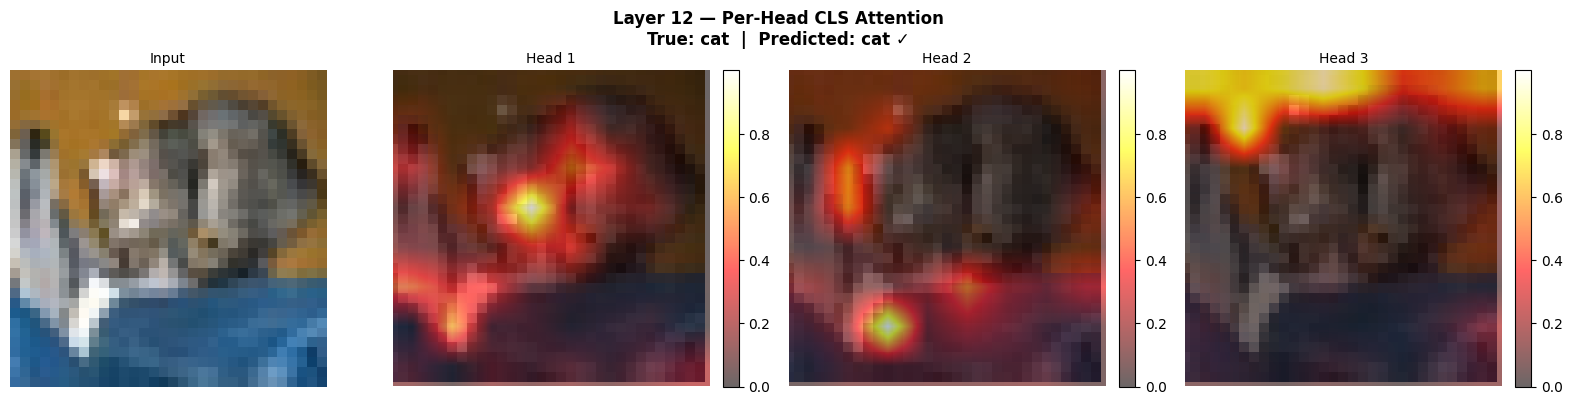

In [8]:
def plot_single_layer_heads(img_tensor, attn_weights, layer_idx, true_label, pred_label, save_path=None):
    num_heads = attn_weights.shape[1]
    grid = _grid(attn_weights)
    img  = denorm(img_tensor[0])

    fig, axes = plt.subplots(1, num_heads + 1, figsize=(4 * (num_heads + 1), 4))
    fig.suptitle(f'Layer {layer_idx + 1} — Per-Head CLS Attention\n{_title(true_label, pred_label)}',
                 fontsize=12, fontweight='bold')

    axes[0].imshow(img); axes[0].set_title('Input', fontsize=10); axes[0].axis('off')

    for h in range(num_heads):
        cls_attn = attn_weights[0, h, 0, 1:].numpy()
        attn_map = _normalise_map(cls_attn.reshape(grid, grid))
        ax = axes[h + 1]
        ax.imshow(img)
        hm = ax.imshow(attn_map, cmap='hot', alpha=0.6,
                       extent=[0, img.shape[1], img.shape[0], 0], interpolation='bilinear')
        ax.set_title(f'Head {h + 1}', fontsize=10); ax.axis('off')
        plt.colorbar(hm, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f'Saved: {save_path}')
    plt.show()
    plt.close(fig)


plot_single_layer_heads(
    img_tensor, all_attn_weights[LAYER], LAYER, true_label, pred_label,
    save_path=f'{SAVE_DIR}/attn_layer{LAYER + 1}_heads.png'
)

## 📊 Plot 2 — CLS Attention Across All Layers

Saved: /kaggle/working/attention_maps/attn_all_layers.png


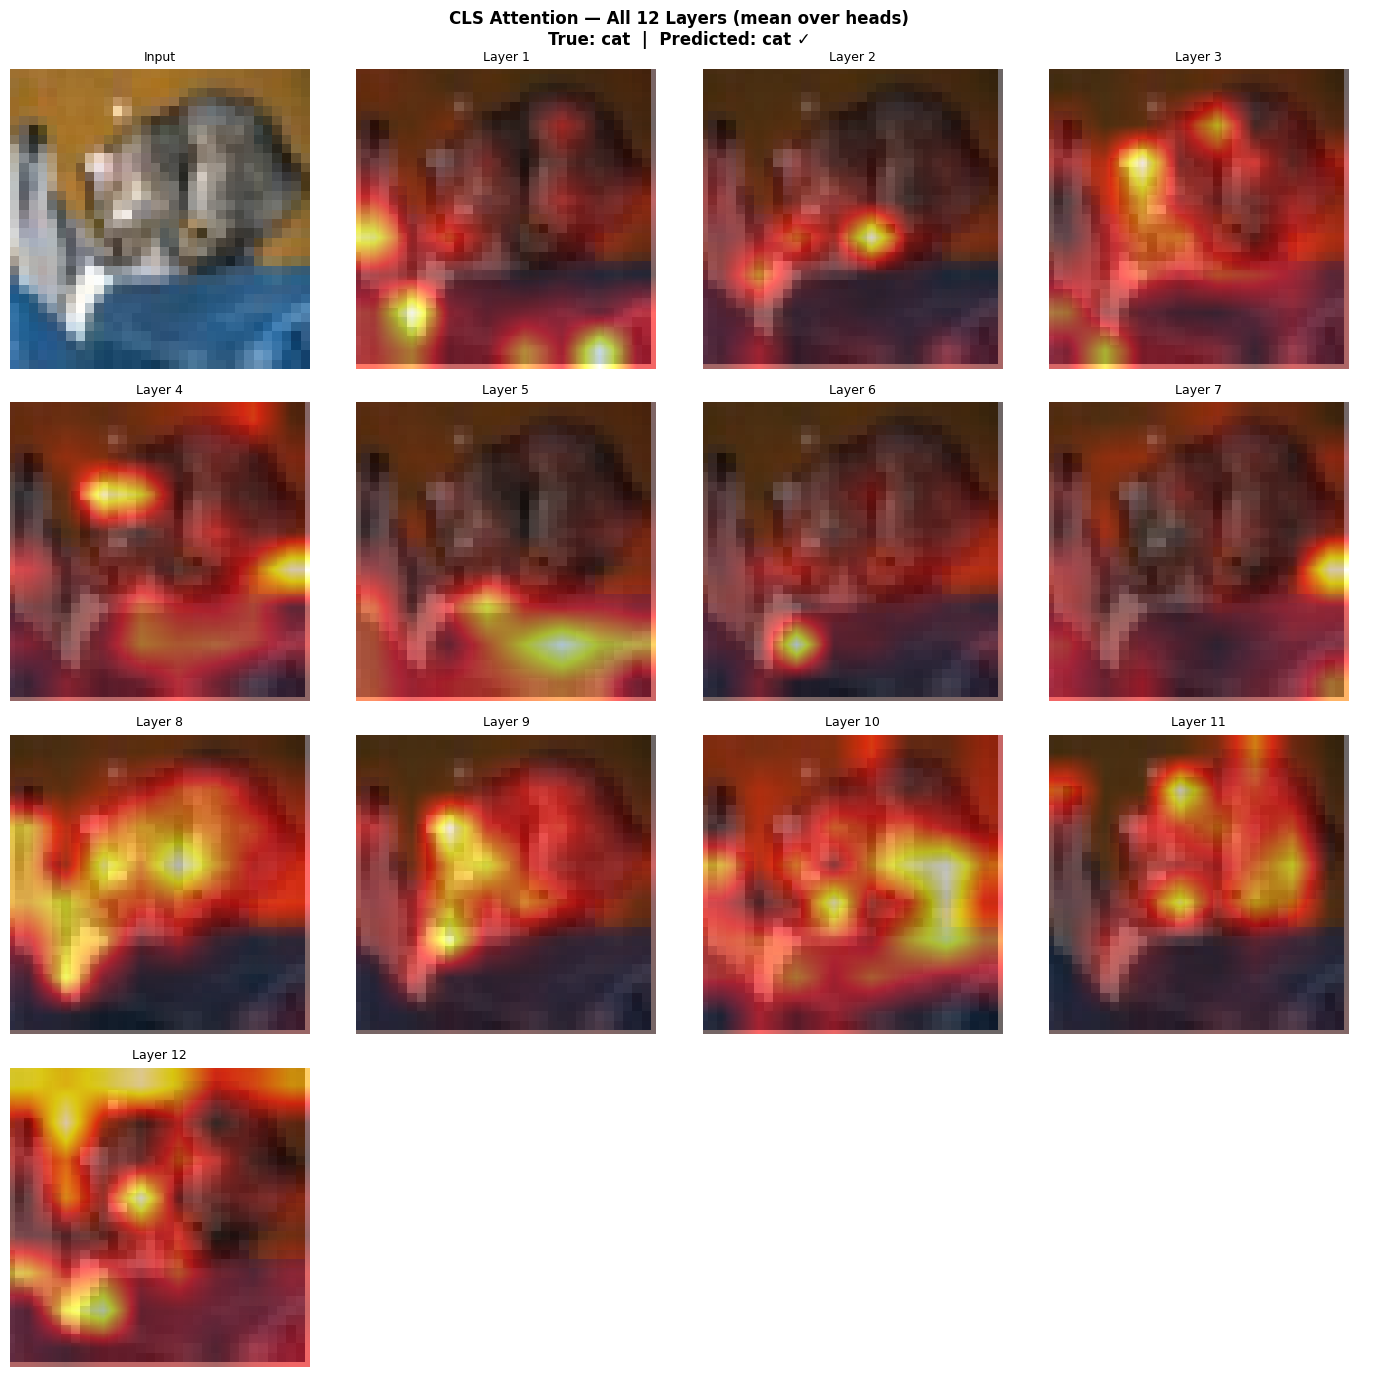

In [9]:
def plot_all_layers_cls_attention(img_tensor, all_attn_weights, true_label, pred_label, save_path=None):
    num_layers = len(all_attn_weights)
    grid = _grid(all_attn_weights[0])
    img  = denorm(img_tensor[0])

    cols = 4
    rows = (num_layers + 1 + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5))
    axes = axes.ravel()

    fig.suptitle(f'CLS Attention — All {num_layers} Layers (mean over heads)\n{_title(true_label, pred_label)}',
                 fontsize=12, fontweight='bold')

    axes[0].imshow(img); axes[0].set_title('Input', fontsize=9); axes[0].axis('off')

    for i, aw in enumerate(all_attn_weights):
        cls_attn = aw[0].numpy().mean(axis=0)[0, 1:]
        attn_map = _normalise_map(cls_attn.reshape(grid, grid))
        ax = axes[i + 1]
        ax.imshow(img)
        ax.imshow(attn_map, cmap='hot', alpha=0.6,
                  extent=[0, img.shape[1], img.shape[0], 0], interpolation='bilinear')
        ax.set_title(f'Layer {i + 1}', fontsize=9); ax.axis('off')

    for i in range(num_layers + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f'Saved: {save_path}')
    plt.show()
    plt.close(fig)


plot_all_layers_cls_attention(
    img_tensor, all_attn_weights, true_label, pred_label,
    save_path=f'{SAVE_DIR}/attn_all_layers.png'
)

## 📊 Plot 3 — Attention Rollout

Saved: /kaggle/working/attention_maps/attn_rollout.png


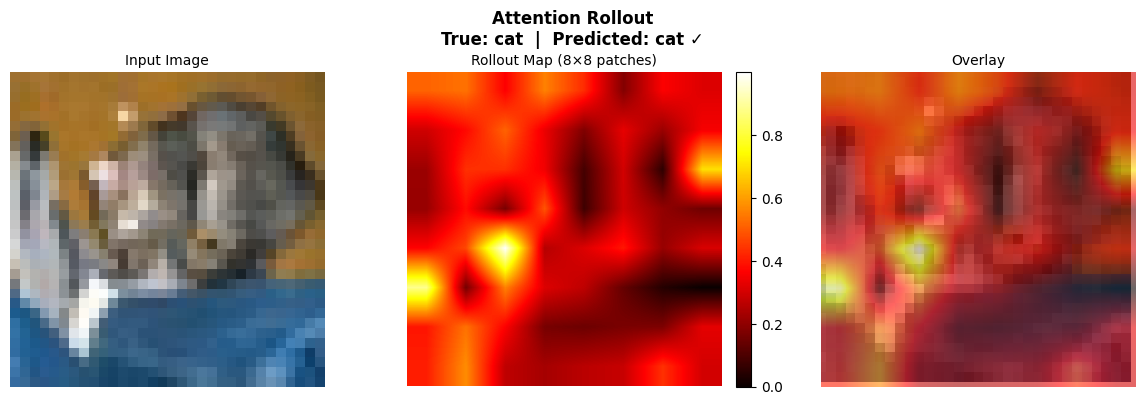

In [10]:
def plot_attention_rollout(img_tensor, all_attn_weights, true_label, pred_label, save_path=None):
    grid = _grid(all_attn_weights[0])
    img  = denorm(img_tensor[0])

    rollout  = attention_rollout(all_attn_weights)
    attn_map = _normalise_map(rollout.reshape(grid, grid))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'Attention Rollout\n{_title(true_label, pred_label)}',
                 fontsize=12, fontweight='bold')

    axes[0].imshow(img); axes[0].set_title('Input Image', fontsize=10); axes[0].axis('off')

    hm = axes[1].imshow(attn_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Rollout Map ({grid}×{grid} patches)', fontsize=10); axes[1].axis('off')
    plt.colorbar(hm, ax=axes[1], fraction=0.046, pad=0.04)

    axes[2].imshow(img)
    axes[2].imshow(attn_map, cmap='hot', alpha=0.6,
                   extent=[0, img.shape[1], img.shape[0], 0], interpolation='bilinear')
    axes[2].set_title('Overlay', fontsize=10); axes[2].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f'Saved: {save_path}')
    plt.show()
    plt.close(fig)


plot_attention_rollout(
    img_tensor, all_attn_weights, true_label, pred_label,
    save_path=f'{SAVE_DIR}/attn_rollout.png'
)

## 💾 Step 8 — Download Plots

In [11]:
import zipfile

zip_path = '/kaggle/working/attention_maps.zip'
with zipfile.ZipFile(zip_path, 'w') as zf:
    for f in Path(SAVE_DIR).glob('*.png'):
        zf.write(f, f.name)

print(f'✓ Zipped all plots → {zip_path}')
print('Download via: Kaggle notebook → Output tab → attention_maps.zip')

✓ Zipped all plots → /kaggle/working/attention_maps.zip
Download via: Kaggle notebook → Output tab → attention_maps.zip
